# Основы глубинного обучения

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети

### Оценивание и штрафы
Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

C:\Temp\ipykernel_13096\4079543086.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
print(device)

cuda


In [2]:
# !wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
# !curl -o data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


: 

In [5]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше работать с такими данными, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [54]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 1

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями.
2. Обучите StandardScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него.

**Примечание**: При разработке модели машинного обучения для проекта всегда желательно иметь некоторую baseline модель. Так нам будет легче проконтролировать, что наша более сложная модель действительно даёт нам прирост качества. Константный прогноз — это метод предсказания, который использует одно фиксированное значение (обычно среднее или медиану) в качестве прогноза для всех входных данных.

In [11]:
# создание бейзлайна 
from sklearn.linear_model import Ridge

model = Ridge(1, random_state=42) # random_state - seed для sklearn

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

scaler = StandardScaler()

In [24]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Add smth here if you need...

In [25]:
set_random_seed(11)

In [56]:
# изменение данных (масштабирование)

X_train = scaler.fit_transform(X_train) #обучение (нахождение правил как трансформировать и трансформация)
X_test = scaler.transform(X_test) #трансвормация (уже есть правила как трансформировать)


In [31]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,1.078786,0.391566,1.826962,0.466361,-0.476621,-0.275266,-1.551924,-1.311105,0.389093,-0.665402,...,-0.084995,0.106413,0.144257,-0.236180,0.047430,-0.355855,0.544084,-0.470477,-0.255366,0.042637
1,0.879511,0.332631,1.748961,0.723345,-0.166769,-1.189729,0.764797,0.109714,1.422683,0.416934,...,-0.314004,0.304413,-0.068758,0.053729,-0.634467,-0.435794,0.556059,0.570861,0.209341,1.161118
2,1.245515,0.592771,1.337550,0.752153,-0.002899,-0.699856,-0.061323,-0.069912,1.167910,-0.073176,...,-0.395974,0.565220,-0.758259,-0.282931,-0.026058,0.223918,-0.508889,-0.338081,0.107828,-0.090122
3,0.799787,-0.061214,0.784000,0.089197,0.327463,-1.297159,0.509977,-1.073557,-0.015553,-1.262565,...,0.586855,-0.562444,-0.479423,-0.890199,-0.796124,0.568335,-0.262505,0.409924,0.973205,0.795200
4,1.247663,0.793377,1.657449,0.449177,-0.408652,-0.564673,-0.692545,-0.952369,0.843389,-0.143557,...,-0.181284,0.097564,0.192974,-0.585048,-0.113758,-0.219524,0.448546,0.258400,0.194381,1.244057


In [12]:
# обучение и предсказание результатов с помощью бейзлайна
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse_ridge = root_mean_squared_error(y_test, y_pred)

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [13]:
y_test_const = np.mean(y_test)
print(y_test_const)
y_test_const_arr = np.full_like(y_test, y_test_const)

best_rmse_metric = root_mean_squared_error(y_test_const_arr, y_pred)

print(f"RMSE Ridge {rmse_ridge}")
print(f"RMSE const {best_rmse_metric}")

1998.4957582800698
RMSE Ridge 9.510160820470434
RMSE const 5.339868154670301


## Задание 2

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики значений функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [10]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: wrl (super_mega_haip_team). Use `wandb login --relogin` to force relogin


True

In [ ]:
# создание тензоров (массив чисел исп для ml и deep потому что хорошо обрабатываются на gpu)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)


# создание даталоудеров (разбиение на батчи, перемешивание)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=1
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=1
)


In [14]:
# функция потерь
def MSE(y_pred, y):
    return ((y - y_pred) ** 2).mean()

In [13]:

wandb.init(project="pytorch-demo")
# сохраняем параметры сетки в wandb + просим следить за градиентами сетки


In [16]:
# ⸂⸂⸜(രᴗര๑)⸝⸃⸃ Good luck!

lin_model = nn.Linear(in_features=90, out_features=1).to(device)
# wandb.watch(lin_model)
# массивы для хранения потерь за каждую эпоху (средние значения по всем батчам в эпохе)
train_losses = []
test_losses = []

lr = 0.05

for i in range(10):
    
    train_losses_epoch = [] # массив для хранения лоссов по батчу
    test_losses_epoch = []

    for x_train, y_train_lin in tqdm(train_dataloader):  # берем батч из трейн лоадера
        y_pred = lin_model(x_train.to(device))  # делаем предсказания
        loss = MSE(y_pred, y_train_lin.to(device))  # считаем лосс
        train_losses_epoch.append(torch.sqrt(loss).detach().cpu().numpy())
        loss.backward()  # считаем градиенты обратным проходом

        # обновление весов без оптимизатора (sgd)
        with torch.no_grad():
            for v in lin_model.parameters():
                v -= lr * v.grad
    
        lin_model.zero_grad()
    
    with torch.no_grad():
        for x_test, y_test_lin in tqdm(test_dataloader):
            y_pred_test = lin_model(x_test.to(device))
            test_loss = MSE(y_pred_test, y_test_lin.to(device))
            test_losses_epoch.append(torch.sqrt(test_loss).cpu().numpy())
    
    
    # wandb.log(
    #     {
    #         "train loss": np.mean(train_losses_epoch),
    #         "test loss": np.mean(test_losses_epoch),
    #     }
    # )

    train_losses.append(np.mean(train_losses_epoch))
    test_losses.append(np.mean(test_losses_epoch))



    print(f"Epoch: {i+1}, Train rmse: {np.mean(train_losses_epoch)}, Test rmse: {np.mean(test_losses_epoch)}")
    
        


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 1, Train rmse: 14.03823184967041, Test rmse: 9.747321128845215


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 2, Train rmse: 10.860387802124023, Test rmse: 9.568021774291992


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 3, Train rmse: 10.853981018066406, Test rmse: 9.642841339111328


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 4, Train rmse: 10.84898567199707, Test rmse: 9.60754680633545


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 5, Train rmse: 10.854689598083496, Test rmse: 9.836392402648926


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 6, Train rmse: 10.855838775634766, Test rmse: 9.7455415725708


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 7, Train rmse: 10.85048770904541, Test rmse: 9.606575965881348


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 8, Train rmse: 10.85341739654541, Test rmse: 9.737456321716309


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 9, Train rmse: 10.986112594604492, Test rmse: 9.850177764892578


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 10, Train rmse: 10.85053825378418, Test rmse: 9.636263847351074


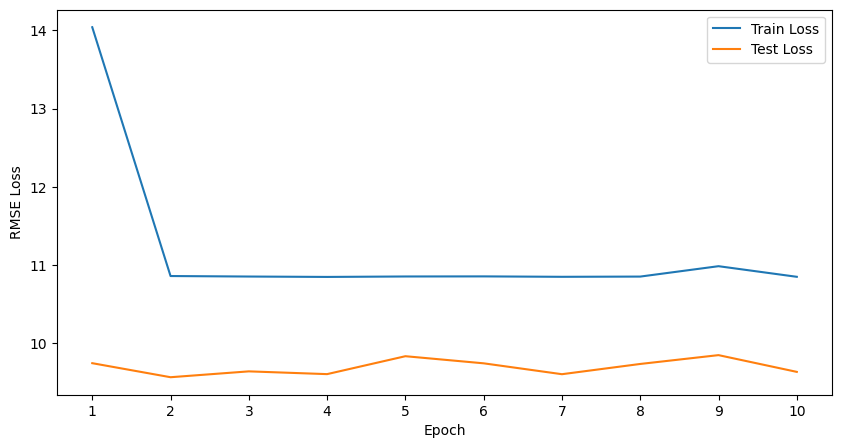

In [17]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, 11, 1), train_losses, label='Train Loss')
plt.plot(np.arange(1, 11, 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('RMSE Loss')
plt.legend()
plt.show()

## Задание 3

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и коэффициентом, применяемым к заданию, следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 0.6
- $\text{RMSE} \le 8.90 $ &mdash; 0.7
- $\text{RMSE} \le 8.80 $ &mdash; 0.8
- $\text{RMSE} \le 8.75 $ &mdash; 1.0

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на **10 баллов**, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]


# изменение данных (масштабирование)

X_train = scaler.fit_transform(X_train) #обучение (нахождение правил как трансформировать и трансформация)
X_test = scaler.transform(X_test) #трансвормация (уже есть правила как трансформировать)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_set = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=64, shuffle=True, num_workers=1
)

test_set = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=64, shuffle=True, num_workers=1
)

In [27]:
model = nn.Sequential(nn.Linear(90, 140),
                      nn.LayerNorm(140),
                      nn.ReLU(),
                      nn.Dropout(0.3),
                      nn.Linear(140, 70),
                      nn.ReLU(),
                      nn.Linear(70, 35),
                      nn.LayerNorm(35),
                      nn.ReLU(),
                      nn.Linear(35,1),
                      ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss() #L1Loss - mae



In [28]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    # (－.－)...zzzZZZzzzZZZ

    # массивы для rmse для графиков
    train_losses = []
    test_losses = []

    for epoch in range(10):
        model.train()

        train_losses_epoch = [] # rmse на обучающей выборке за эпоху
        test_losses_epoch = [] # rmse на тестовой выборке за эпоху

        for x_train, y_train_model in tqdm(train_loader):  # берем батч из трейн лоадера
            y_pred = model(x_train.to(device))  # делаем предсказания
            loss = criterion(y_pred.squeeze(), y_train_model.to(device))  # считаем лосс mse
            train_losses_epoch.append(torch.sqrt(loss).detach().cpu().numpy())
            loss.backward()  # считаем градиенты обратным проходом
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            for X_test, y_test_model in tqdm(test_loader):
                y_pred_test = model(X_test.to(device))
                test_loss = criterion(y_pred_test.squeeze(), y_test_model.to(device))
                test_losses_epoch.append(torch.sqrt(test_loss).cpu().numpy())
                
                    
        train_losses.append(np.mean(train_losses_epoch))
        test_losses.append(np.mean(test_losses_epoch))            


        print(f"Epoch: {epoch+1}, Train RMSE: {np.mean(train_losses_epoch)}, Test RMSE: {np.mean(test_losses_epoch)}")
        

    paint_graphic(train_losses, "Train loss")
    paint_graphic(test_losses, "Test loss")




def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    # (－.－)...zzzZZZzzzZZZ
    model.eval()
    predictions = [] # предсказания
    losses = [] # rmse
    

    with torch.no_grad():
        for X_test, y_test_model in tqdm(test_loader):
            y_pred_test = model(X_test.to(device))
            test_loss = criterion(y_pred_test.squeeze(), y_test_model.to(device))
            predictions.append(y_pred_test.cpu())

            losses.append(torch.sqrt(test_loss).cpu().numpy())
            
            
    print(f"RMSE: {np.mean(losses)}")    

    predicts = torch.cat(predictions)

    return predicts


def paint_graphic(losses, loss_type, num_epochs = 10):
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1, num_epochs+1, 1), losses, label=loss_type)
    plt.xlabel('Epoch')
    plt.xticks(np.arange(1, num_epochs+1, 1))
    plt.ylabel('RMSE Loss')
    plt.legend()
    plt.show()


In [23]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

  0%|          | 0/807 [00:00<?, ?it/s]

RMSE: 8.645354270935059


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 1, Train RMSE: 1191.922119140625, Test RMSE: 155.38101196289062


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 2, Train RMSE: 20.503890991210938, Test RMSE: 8.814994812011719


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 3, Train RMSE: 8.740779876708984, Test RMSE: 8.737469673156738


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 4, Train RMSE: 8.676125526428223, Test RMSE: 8.703697204589844


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 5, Train RMSE: 8.631634712219238, Test RMSE: 8.694817543029785


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 6, Train RMSE: 8.592851638793945, Test RMSE: 8.687602996826172


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 7, Train RMSE: 8.56137466430664, Test RMSE: 8.660110473632812


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 8, Train RMSE: 8.536571502685547, Test RMSE: 8.651850700378418


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 9, Train RMSE: 8.510025024414062, Test RMSE: 8.69072151184082


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 10, Train RMSE: 8.487543106079102, Test RMSE: 8.650774002075195


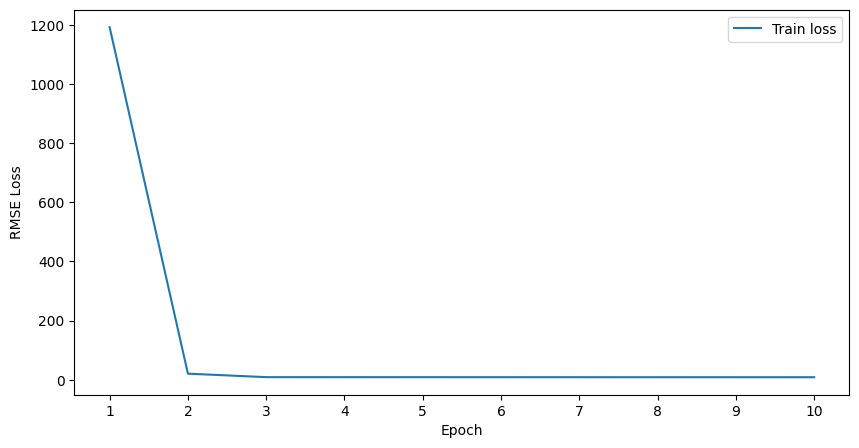

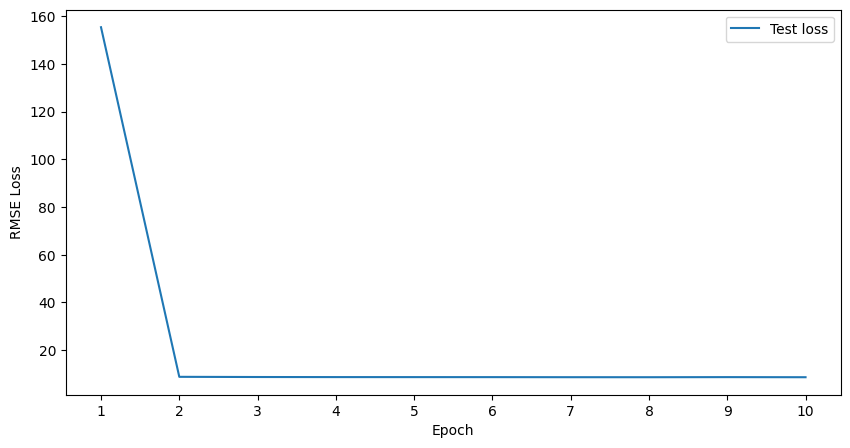

  0%|          | 0/807 [00:00<?, ?it/s]

RMSE: 8.654122352600098


In [29]:
# ೭੧(❛〜❛✿)੭೨ Go forward!

train(model, optimizer, criterion, train_loader, test_loader)
pred = test(model, criterion, test_loader)


## Задание 4 
(0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

**Все эксперименты проводились с обучением на 10 эпохах, размер батча 64.**

1. Standart scaler, loss: mse, SGD,  lr = 0.05, два слоя линейных linear(90, 30) relu linear(30, 1)             
    train rmse 200, test rmse много

2. Standart scaler, loss: mse, **Adam**, lr = 0.05, два слоя линейных linear(90, 30) relu linear(30, 1)         
    train rmse 15.4, test rmse 15.23

Оптимизатор Adam значительно улучшил результаты, поэтому в дальнейшем будем использовать его.

3. Standart scaler, loss: **mae**, Adam, lr = 0.05, два слоя линейных linear(90, 30) relu linear(30, 1)         
    train rmse 15.49, test rmse 14.32

MAE незначительно улучшило показатель, но из-за неудобства расчета RMSE я не буду использовать MAE в следующих экспериментах

4. **MinMax scaler, loss: mse**, Adam, lr = 0.05, два слоя линейных linear(90, 30) relu linear(30, 1)          
    train rmse 15.49, test rmse 11.8

5. MinMax scaler, loss: mse, Adam, **lr = 0.1**, два слоя линейных linear(90, 30) relu linear(30, 1)            
    train rmse 12.79, test rmse 14.5

6. MinMax scaler, loss: mse, Adam, lr = 0.05, **3 слоя линейных linear(90, 64) relu linear(64,32) relu linear(32,1)**     
    train rmse 14.07, test rmse 14.06

7. MinMax scaler, loss: mse, Adam, lr = 0.05, **3 слоя линейных linear(90, 45) relu dropout(30%) linear(45,45) relu linear(45, 1)**      
    train rmse 11.35, test rmse 10.84

8. MinMax scaler, loss: mse, Adam, lr = 0.05, **5 слоя линейных linear(90, 128) relu dropout(30%) linear(128,256) relu dropout(30%) linear(256,64) relu linear(64,32) relu linear(32,1)**      
    train rmse 11.28, test rmse 10.75

9. **Standart scaler**, loss: mse, Adam, **lr = 0.001**, **4 слоя линейных linear(90, 128) relu dropout(30%) linear(128,64) relu dropout(30%) linear(64,32) relu linear(32,1)**      
    train rmse 8.85, test rmse 8.79

Сначала смена скейлера улучшила результаты, но в других экспериментах с другой архитектурой и с standart scaler показатель метрики был ниже

10. Standart scaler loss: mse, Adam, lr = 0.001, **4 слоя линейных linear(90, 180) relu dropout(30%) linear(180,120) relu dropout(30%) linear(120,60) relu linear(60,1)**      
    train rmse 9.2, test rmse 8.9

11. Standart scaler loss: mse, Adam, lr = 0.001, **4 слоя линейных linear(90, 180) relu dropout(30%) linear(180,60) relu dropout(30%) linear(60,30) relu linear(30,1)**      
    train rmse 8.85, test rmse 8.85

12. Standart scaler loss: mse, Adam, lr = 0.001, **4 слоя линейных linear(90, 180)  relu dropout(30%) linear(180,120) relu dropout(30%) linear(120,60) relu linear(60,1)**      
    train rmse 8.84, test rmse 8.77

13. Standart scaler, loss: mse, Adam, lr = 0.001, **linear(90,140) layerNorm(140) relu dropout(30%) linear(140,70) relu linear(70,35) layerNorm(35) relu linear(35,1)**
    train rmse 8.49, test rmse 8.65

  __________________________________________________________________________________________________________________________________________________________________________________________________________________________________
  
  

После нахождения оптимальных параметров (оптимизатор Adam, функция потерь MSE, lr = 0.001), нужно было подобрать архитектуру и количество нейронов в слоях, которые бы показывали хороший результат.

Очень улучшило результаты смена оптимизатора с SGD на Adam и незначительно помогла смена функции потерь (с MSE на MAE), но потом я отказался от MAE из-за плохих результатов. Уменьшение гиперпараметра lr понизило ошибку, а увеличение только ухудшило результаты. Dropout и LayerNorm помогли довести модель до состояния, когда она предсказывала хорошие значения и RMSE был низок.

Финальные результаты получились с моделью номер 13, с показателем RMSE на тестовой выборке 8.65


https://www.kaggle.com/code/raghav1810/release-year-prediction-on-msd/notebook

https://neurohive.io/ru/tutorial/glubokoe-obuchenie-s-pytorch/

https://qudata.com/ml/ru/NN_Base_Torch_NN_Ref.html#BatchNorm1d